In [ ]:
### Prediction 1: KNN

In [57]:
import pandas as pd
import numpy as np
import nltk
import random
import time
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from copy import copy, deepcopy
import collections
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from pandas.tseries.offsets import *
lmtzr=WordNetLemmatizer()
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib

In [42]:
data_ads = "/home/hs2865/web2/data/"
user_raw = pd.read_csv(data_ads + "wow3_user2.csv", names = ["user_id", "review_count", "average_stars", 
                                               "friends", "fans", "votes_cool", "votes_funny", 
                                               "votes_useful", "num", "degree", "coefficient"])

business_raw = pd.read_csv(data_ads+"wow3_business_mysql.csv", names = ["business_id", "name", "latitude", 
                                                           "longitude", "stars", "categories", 
                                                           "review_count", "open"])
review_raw = pd.read_csv(data_ads+"wow3_review_mysql.csv", names = ["review_id", "user_id", "business_id", 
                                                       "stars", "text", "date", "votes_funny", 
                                                       "votes_useful"])
all_raw = pd.read_csv(data_ads+"wow3_all2.csv", names = ["business_id", 
                                                       "name", "stars_business","business_review_count",
                                                       "categories", "open", "review_id", 
                                                       "stars_review", "text", "date", "votes_funny", 
                                                       "votes_useful","user_id", "user_review_count", 
                                                       "average_stars","friends", "fans", "num", 
                                                       "degree", "coefficient"])

In [43]:
# Train
typ ='Restaurants'
weight =100
bus_gb_df = deepcopy(all_raw)
#Group by different businesses for different rates:
bus_df = bus_gb_df.groupby(['business_id']).mean()

bus_df['business_id'] = bus_df.index
bus_df.index = range(len(bus_df))
bus = list(set(bus_df['business_id']))
ind = [True if i in bus else False for i in business_raw['business_id']]
business_revised = business_raw[ind]

#Merge two tables:
knn_df = pd.merge(bus_df,business_revised,on='business_id')

#Only choose open business for recommendation:
knn_df_open = knn_df[knn_df['open']=="T"]

#Filter the type of business:
ind = [True if typ in i else False for i in knn_df_open.categories.values]
knn_df_open_typ = knn_df_open[ind]

#Set training data:
trainX = knn_df_open_typ[['stars_business','stars_review','average_stars','latitude','longitude']]
trainX['latitude'] = trainX['latitude'].map(lambda x:x*weight)
trainX['longitude'] = trainX['longitude'].map(lambda x:x*weight)
#trainY = knn_df_open[['business_id']]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [70]:
num_recommend = 20
prediction1 = NearestNeighbors(n_neighbors=num_recommend)
prediction1.fit(trainX)
joblib.dump(prediction1, 'prediction1.pkl') 

['prediction1.pkl']

In [77]:
knn_df_open_typ.to_pickle("knn_df_open_typ")

In [78]:
def prediction1(lat, lng):
    latitude = lat
    longitude = lng    

    longitude *= weight
    latitude *= weight
    testX = [5,5,5,latitude,longitude]
    prediction1 = joblib.load('prediction1.pkl') 
    result = prediction1.kneighbors(testX)
    knn_df_open_typ = read_pickle("knn_df_open_typ")
    return knn_df_open_typ.iloc[result[1][0]]

In [72]:
result_pred1 = prediction1(40.3719, -80.0089)
type(result_pred1)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


pandas.core.frame.DataFrame

In [74]:
print result_pred1
#print result_pred1.to_json(orient='index')

      stars_business  business_review_count  stars_review  votes_funny  \
2404             4.0                    9.0      3.833333     0.000000   
2959             4.5                   26.0      4.500000     0.041667   
1533             4.5                    3.0      5.000000     0.000000   
475              4.0                   20.0      3.941176     0.529412   
3456             4.5                   27.0      4.346154     0.384615   
2250             3.5                    3.0      4.000000     0.000000   
2854             4.0                   70.0      4.000000     0.109375   
2282             4.0                   52.0      3.872340     0.127660   
473              4.0                   14.0      3.800000     0.000000   
1531             4.0                   24.0      4.047619     0.380952   
3172             4.5                   11.0      4.625000     0.375000   
2688             4.0                   80.0      4.026667     0.173333   
3592             4.0                  

In [76]:
type(knn_df_open_typ)

pandas.core.frame.DataFrame

In [ ]:
### Prediction 3: Rate prediction

In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import nltk
import random
import time
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from copy import copy, deepcopy
import collections
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
lmtzr=WordNetLemmatizer()


In [4]:
data = '/home/hs2865/web2/data/'
user_raw = pd.read_csv(data + "wow3_user2.csv", names = ["user_id", "review_count", "average_stars", 
                                               "friends", "fans", "votes_cool", "votes_funny", 
                                               "votes_useful", "num", "degree", "coefficient"])

business_raw = pd.read_csv(data + "wow3_business_mysql.csv", names = ["business_id", "name", "latitude", 
                                                           "longitude", "stars", "categories", 
                                                           "review_count", "open"])

review_raw = pd.read_csv(data + "wow3_review_mysql.csv", names = ["review_id", "user_id", "business_id", 
                                                       "stars", "text", "date", "votes_funny", 
                                                       "votes_useful"])

all_raw = pd.read_csv(data + "wow3_all2.csv", names = ["business_id", 
                                                       "name", "stars_business","business_review_count",
                                                       "categories", "open", "review_id", 
                                                       "stars_review", "text", "date", "votes_funny", 
                                                       "votes_useful","user_id", "user_review_count", 
                                                       "average_stars","friends", "fans", "num", 
                                                       "degree", "coefficient"])


In [39]:
def prediction3(business_id):
    #3. Business Rate Prediction(Time Series):
    #Input: a given business_id
    #Output: predicted result of next month's rate and model data visualization
    #business_id = 'SsGNAc9U-aKPZccnaDtFkA'
    sub_business = all_raw[all_raw['business_id']==business_id]
    if len(sub_business) == 0:
        return
    dates = [datetime.strptime(date,'%Y-%m-%d') for date in sub_business.date.values]
    rate_predict = pd.DataFrame()
    rate_predict['rate'] = pd.Series(sub_business.stars_review.values,index = pd.Series(dates))
    #Aggregation: group by month and take average
    g = rate_predict.groupby(pd.TimeGrouper("M"))
    rate_predict_avg = g.mean()
    #Rolling mean(Moving Average) of the monthly prediction:
    moving_avg = pd.rolling_mean(rate_predict_avg,12)
    rate_predict_moving_avg_diff = rate_predict_avg - moving_avg
    decomposition = seasonal_decompose(rate_predict_avg)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    rate_predict_log_decompose = residual
    rate_predict_log_decompose.dropna(inplace=True)
    model = ARIMA(rate_predict_avg, order=(1, 1, 0))  
    results_AR = model.fit(disp=-1)  
    save_business_id = business_id.replace('-', '_')
    rate_predict_log_decompose.to_csv('predict3/' + save_business_id + '_actual.csv', header=False)
    results_AR.fittedvalues.to_csv('predict3/' + save_business_id + '_prediction.csv', header=False)

In [40]:
error = []
for i in range(len(business_raw)):
    try:
        prediction3(business_raw['business_id'][i])
    except:
        #print business_raw['business_id'][i]
        error.append(business_raw['business_id'][i])
error_pd = pd.DataFrame(error)
error_pd.to_csv('predict3/error.csv', index=False, header=False)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()


In [5]:
#3. Business Rate Prediction(Time Series):
#Input: a given business_id
#Output: predicted result of next month's rate and model data visualization
business_id = 'SsGNAc9U-aKPZccnaDtFkA'
sub_business = all_raw[all_raw['business_id']==business_id]
dates = [datetime.strptime(date,'%Y-%m-%d') for date in sub_business.date.values]
rate_predict = pd.DataFrame()
rate_predict['rate'] = pd.Series(sub_business.stars_review.values,index = pd.Series(dates))

In [6]:
#Aggregation: group by month and take average
g = rate_predict.groupby(pd.TimeGrouper("M"))
rate_predict_avg = g.mean()

In [7]:
#Rolling mean(Moving Average) of the monthly prediction:
moving_avg = pd.rolling_mean(rate_predict_avg,12)

rate_predict_moving_avg_diff = rate_predict_avg - moving_avg

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  from ipykernel import kernelapp as app


In [9]:
decomposition = seasonal_decompose(rate_predict_avg)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

rate_predict_log_decompose = residual
rate_predict_log_decompose.dropna(inplace=True)

/usr/lib/python2.7/dist-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


5.1994639518


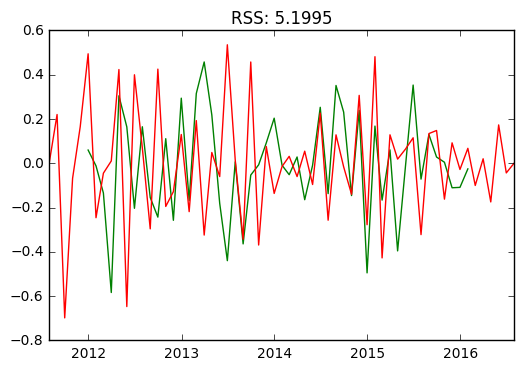

In [10]:
model = ARIMA(rate_predict_avg, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
rate_predict_log_decompose.to_csv('predict3/' + business_id + 'actual.csv', header=False)
results_AR.fittedvalues.to_csv('predict3/' + business_id + 'prediction.csv', header=False)

common = list(set(results_AR.fittedvalues.index).intersection(set(rate_predict_log_decompose.index)))

'''
plt.plot(rate_predict_log_decompose,color = 'green')
plt.plot(results_AR.fittedvalues, color='red')

res = 0.0
for i in range(len(common)):
    res+=(rate_predict_log_decompose[rate_predict_log_decompose.index==common[i]].values[0][0] - results_AR.fittedvalues[results_AR.fittedvalues.index==common[i]].values[0])**2
print res
plt.title('RSS: %.4f'% res)

#plt.savefig('data.png', dpi = 75)  
plt.show()  
'''